In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import google.generativeai as genai
import time
from collections import Counter
from typing import List, Dict, Any
import random

In [2]:
os.environ['API_KEY']
#uncomment if API key not in env and add it

In [3]:
base_prompt = """You are Steve Jobs. Respond to questions in his distinctive voice and style.

Only output the response Steve Jobs style, nothing else

Here is the question to answer as Steve Jobs:
{question}"""
useful_qa_pairs = json.load(open('useful_qa_pairs1.json'))
NUM_TODO = 50
MAX_OUTPUT_TOKENS = 400
TEMP = 0.3
TOP_P = 0.8

# Setup Model (~ 10 mins)

In [4]:
model_name = 'gemini-2.0-flash-exp'
genai.configure(api_key=os.environ['API_KEY'])
model = genai.GenerativeModel(model_name)

#safety off
safe = [
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "BLOCK_NONE",
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "BLOCK_NONE",
        },
        {
            "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
            "threshold": "BLOCK_NONE",
        },
        {
            "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
            "threshold": "BLOCK_NONE",
        },
]

def generate(prompt, max_output_tokens=300, **kwargs):
    generation_config = genai.types.GenerationConfig(max_output_tokens=max_output_tokens, **kwargs)
    try:
        response = model.generate_content(prompt, safety_settings=safe, generation_config=generation_config)
    except:
        print('Retrying')
        time.sleep(5)
        response = model.generate_content(prompt, safety_settings=safe, generation_config=generation_config)
    return response.text

#test model
generate('Give Introduction to VR as Mark Zuckerberg. Just output the intro.', 
        max_output_tokens=50, temperature=0.5, top_p=0.5)

"Alright, hey everyone. Mark here. We're at a really exciting point in technology, a point where we're not just looking at screens, but stepping *inside* them. And that's what I want to talk to you about"

# Evaluations

In [5]:
from sentence_transformers import SentenceTransformer
import spacy
from scipy.spatial.distance import cosine
import gensim.downloader as api
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')
gensim_model = api.load('word2vec-google-news-300')
sentence_model = SentenceTransformer('all-mpnet-base-v2')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ved67\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]

def word_mover_distance(real_answer, generated_answer):
    real_sent = preprocess(real_answer)
    generated_sent = preprocess(generated_answer)
    return gensim_model.wmdistance(real_sent, generated_sent)
    
def get_embedding_similarity(real_answer, generated_answer):
    real_embedding = sentence_model.encode(real_answer)
    generated_embedding = sentence_model.encode(generated_answer)
    
    # Calculate cosine similarity
    similarity = 1 - cosine(real_embedding, generated_embedding)
    return similarity

def compare_features(real_features, gen_features):
    scores = {}
    
    # Compare POS tag distributions
    scores['pos_similarity'] = compare_distributions(
        list(real_features['pos_distribution'].values()),
        list(gen_features['pos_distribution'].values())
    )
    
    # Compare dependency patterns
    scores['dependency_similarity'] = compare_sequences(
        real_features['dependency_patterns'],
        gen_features['dependency_patterns']
    )
    
    return scores

def compare_distributions(dist1, dist2, epsilon=1e-10):
    p = np.array(dist1, dtype=float)
    q = np.array(dist2, dtype=float)
    
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    len_p = len(p)
    len_q = len(q)
    
    min_len = min(len_p, len_q)
    intersection = np.minimum(p[:min_len], q[:min_len]).sum()
    
    length_diff_penalty = 0 #abs(len_p - len_q) / max(len_p, len_q)
    
    similarity = intersection * (1 - length_diff_penalty)
    
    return similarity

def compare_sequences(seq1, seq2):
    """
    Compare two sequences of categorical values using overlap coefficient
    """
    # Convert to frequency distributions
    freq1 = Counter(seq1)
    freq2 = Counter(seq2)
    
    # Calculate overlap coefficient
    intersection = sum((freq1 & freq2).values())
    min_size = min(sum(freq1.values()), sum(freq2.values()))
    
    return intersection / min_size if min_size > 0 else 0.0

def compare_linguistic_features(real_answer, generated_answer):
    nlp = spacy.load('en_core_web_sm')
    
    def get_features(text):
        doc = nlp(text)
        return {
            'pos_distribution': {pos: count/len(doc) for pos, count 
                               in doc.count_by(spacy.attrs.POS).items()},
            'dependency_patterns': [token.dep_ for token in doc],
        }
    
    real_features = get_features(real_answer)
    gen_features = get_features(generated_answer)
    return compare_features(real_features, gen_features)

In [7]:
os.environ['ANTHROPIC_API_KEY'] = 

In [8]:
import requests

def generate_claude(prompt, max_tokens=50):
    url = 'https://api.anthropic.com/v1/messages'
    headers = {
        "x-api-key": os.environ['ANTHROPIC_API_KEY'],
        "anthropic-version": "2023-06-01",
        "content-type": "application/json"
    }

    data = {
        "model": "claude-3-5-haiku-20241022",
        "max_tokens": max_tokens,
        "temperature": 0.2,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ]
    }

    try:
        response = requests.post(url, headers=headers, json=data)
        response_data = response.json()
        time.sleep(0.5)
    except:
        print(response.text)
        time.sleep(2)
        response = requests.post(url, headers=headers, json=data)
        response_data = response.json()
    return response_data['content'][0]['text']

def evaluate_claude(real_answer, generated_answer):
    style_eval_prompt = """
    You are evaluating how well a generated response matches Steve Jobs' speaking style. Compare the generated response to these key style elements:

    1. Storytelling & Anecdotes (0-10):
    - Does it use personal stories or examples?
    - Does it build up to a point?

    2. Language Patterns (0-10):
    - Uses characteristic phrases ("Let me...", "I remember...")
    - Maintains his conversational yet authoritative tone

    3. Structure (0-10):
    - Starts broad then focuses in
    - Uses analogies or metaphors
    - Circles back to main points
    
    4. Content (0-10):
    - Addresses the question directly
    - Are the key points in the generated answer similar to the real answer?
    - Does it provide a clear response like Steve Jobs would?
    

    Compare these responses:
    Real Steve Jobs: {real_answer}
    Generated Response: {generated_answer}

    Only score the generated response, the real response is given as reference
    Also only output the score, and a very brief justification for each category, nothing else
    Then sum all scores and give overall score(0-40) formatted as
    Overall Match Score: X/40
        """

    prompt = style_eval_prompt.format(
        real_answer=real_answer,
        generated_answer=generated_answer
    )
    return generate_claude(prompt, max_tokens=250)

In [9]:
import re

def get_style_similarity(real_answer, generated_answer):
    """Calculate semantic similarity between answers using embeddings"""
    embedding_sim = get_embedding_similarity(real_answer, generated_answer)
    wmd_score = 1 / (1 + word_mover_distance(real_answer, generated_answer))  # Normalize WMD
    return (embedding_sim + wmd_score) / 2

def compare_llm_eval(real_answer, generated_answer):
    """Use Claude to evaluate style similarity"""
    evaluation = evaluate_claude(real_answer, generated_answer)
    match = re.search(r"Overall Match Score: (\d+)/40", evaluation)
    if match:
        overall_score = int(match.group(1)) / 40
        return overall_score
    else:
        print('fail', evaluation)
        return 0.5  # Default score if parsing fails

def evaluate_style_match(real_answer, generated_answer):
    """Comprehensive style evaluation combining multiple metrics"""
    style_sim = get_style_similarity(real_answer, generated_answer)
    
    ling_features = compare_linguistic_features(real_answer, generated_answer)
    ling_score = sum(ling_features.values()) / len(ling_features)
    

    llm_score = compare_llm_eval(real_answer, generated_answer)
    
    scores = {
        'embedding_similarity': style_sim,
        'linguistic_match': ling_score,
        'llm_score': llm_score
    }
    
    weighted_score = (
        scores['embedding_similarity'] * 0.35 +
        scores['linguistic_match'] * 0.35 +
        scores['llm_score'] * 0.3
    )
    
    return {
        'detailed_scores': scores,
        'overall_score': weighted_score,
        'linguistic_details': ling_features
    }

In [10]:
import textwrap
from termcolor import colored
import difflib
def pretty_print_qa_comparison(
    index: int,
    question: str,
    original_answer: str,
    model_answer1: str,
    model_answer2: str,
    scores: Dict[str, Any] = None,
    width: int = 80
):
    def wrap_text(text: str) -> str:
        paragraphs = text.split('\n')
        wrapped = [textwrap.fill(p.strip(), width=width) for p in paragraphs]
        return '\n'.join(wrapped)
    
    def get_similarity_markup(text1: str, text2: str) -> str:
        d = difflib.SequenceMatcher(None, text1, text2)
        similarity = d.ratio() * 100
        return f"{similarity:.1f}% similar to initial model answer"
    
    print("\n" + "="* width)
    print(colored(f"QA Pair {index}", "cyan", attrs=['bold']))
    print("=" * width + "\n")
    
    print(colored("Question:", "yellow", attrs=['bold']))
    print(wrap_text(question))
    print("\n" + "-" * width + "\n")
    
    print(colored("Original Steve Jobs Answer:", "green", attrs=['bold']))
    print(wrap_text(original_answer))
    print("\n" + "-" * width + "\n")
    
    print(colored("Initial Model Response:", "blue", attrs=['bold']))
    print(wrap_text(model_answer1))
    print("\n" + "-" * width + "\n")
    
    print(colored("Improved Model Response:", "magenta", attrs=['bold']))
    similarity2 = get_similarity_markup(model_answer1, model_answer2)
    print(colored(f"[{similarity2}]", "cyan"))
    print(wrap_text(model_answer2))
    
    if scores:
        print("\n" + "-" * width)
        print(colored("Evaluation Metrics:", "yellow", attrs=['bold']))
        for metric, score in scores.items():
            print(f"{metric}: {score:.3f}")
    
    print("\n" + "=" * width + "\n")

def compare_qa_pairs(qa_results, final_results, num_pairs=5, offset=0):
    for i in range(offset, min(num_pairs+offset, len(qa_results))):
        qa = qa_results[i]
        improved_response = final_results['train_set_results']['results'][i]['qa']['model_response']
        
        # Get evaluation scores if available
        scores = None
        if 'eval' in final_results['train_set_results']['results'][i]:
            scores = final_results['train_set_results']['results'][i]['eval']['detailed_scores']
        
        pretty_print_qa_comparison(
            i + 1,
            qa['question'],
            qa['answer'],
            qa['model_response'],
            improved_response,
            scores=scores
        )

In [11]:
def evaluate_dataset(qa_results, k=10):
    """Evaluate all QA pairs and compute aggregate metrics"""
    train_results = qa_results[:-k]
    test_results = qa_results[-k:]
    
    def evaluate_set(dataset):
        scores = []
        for qa in dataset:
            eval_result = evaluate_style_match(qa['answer'], qa['model_response'])
            scores.append(eval_result)
        return scores
    
    train_scores = evaluate_set(train_results)
    test_scores = evaluate_set(test_results)
    
    return {
        'train': {
            'scores': train_scores,
            'avg_score': sum(s['overall_score'] for s in train_scores) / len(train_scores)
        },
        'test': {
            'scores': test_scores,
            'avg_score': sum(s['overall_score'] for s in test_scores) / len(test_scores)
        }
    }

# Optimizer

In [12]:
class PromptOptimizer:
    def __init__(self, base_prompt: str, qa_results: List[Dict], eval_results: Dict):
        self.base_prompt = base_prompt
        self.qa_results = qa_results
        self.eval_results = eval_results
        self.optimization_history = []
        
    def analyze_weak_points(self, scores: List[Dict]) -> Dict[str, float]:
        aggregated_scores = {
            'embedding_similarity': [],
            'linguistic_match': [],
            'llm_score': []
        }
        
        for score in scores:
            for key in aggregated_scores:
                aggregated_scores[key].append(score['detailed_scores'][key])
                
        return {k: np.mean(v) for k, v in aggregated_scores.items()}
    
    def get_improvement_suggestions(self, weak_points: Dict[str, float], 
                                  sample_qa: List[Dict]) -> str:
        analysis_prompt = f"""
        As a prompt optimization expert, analyze these evaluation results and suggest specific improvements
        to this base prompt to better match Steve Jobs' speaking style:

        Current Prompt:
        {self.base_prompt}

        Evaluation Scores:
        {json.dumps(weak_points, indent=2)}

        Sample Question/Answer Pairs for Reference, we want the model response to match the style of answer and also have similar content to some extent as much as possible.
        {json.dumps(sample_qa[:3], indent=2)}

        Focus on:
        1. What elements of Jobs' speaking style are missing
        2. How to better capture his thought process
        3. Specific prompt modifications to improve the lowest scoring areas
        4. What context or constraints should be added
        5. How to make the prompt such that the evaluations scores improve
        6. The evaluation score has multiple metrics that measure style similarity and to some extend content similarity, so focus on improving these areas

        Provide specific prompt text modifications, not just general suggestions.
        """
        
        return generate(analysis_prompt, max_output_tokens=500, temperature=0.6, top_p=0.8)
    
    def extract_prompt_modifications(self, suggestions: str, current_prompt: str) -> str:
        extraction_prompt = f"""
        Current base prompt:
        {current_prompt}
        
        We need to improve the base prompt with the specific prompt modifications from these suggestions:
        {suggestions}

        Output only the new complete base prompt text, maintaining the same basic structure but with 
        improvements incorporated. Keep the dynamic question placeholder {{question}}.
        The reponse should be in the format exactly:
        New Prompt: <your new prompt here>
        """
        
        response = generate(extraction_prompt, max_output_tokens=500, temperature=0.6, top_p=0.8)
        match = re.search(r"New Prompt: (.+)", response)
        if match:
            return match.group(1).strip()
        else:
            print('Prompt extraction failed')
    
    def evaluate_prompt_version(self, new_prompt: str, 
                              test_subset: List[Dict], 
                              sleep_time: int = 6) -> Dict[str, Any]:
        test_results = []
        
        for qa in test_subset:
            prompt = new_prompt.format(question=qa['question'])
            response = generate(prompt, max_output_tokens=MAX_OUTPUT_TOKENS, temperature=TEMP, top_p=TOP_P)
            time.sleep(sleep_time)
            
            qa_result = qa.copy()
            qa_result['model_response'] = response
            qa_result['prompt'] = prompt
            
            eval_result = evaluate_style_match(qa['answer'], response)
            test_results.append({
                'qa': qa_result,
                'eval': eval_result
            })
            
        avg_score = np.mean([r['eval']['overall_score'] for r in test_results])
        return {
            'prompt': new_prompt,
            'results': test_results,
            'average_score': avg_score
        }
    
    def optimize_prompt(self, num_iterations: int = 2, 
                       test_size: int = 5,
                       improvement_threshold: float = 0.02) -> Dict[str, Any]:
        current_prompt = self.base_prompt
        best_prompt = current_prompt
        test_ids = random.sample(list(np.arange(40)), test_size)
        test_subset = []
        best_score = 0
        best_scores_details = []
        for i in test_ids:
            test_subset.append(self.qa_results[i])
            best_score += self.eval_results['train']['scores'][i]['overall_score']
            best_scores_details.append((self.qa_results[i]['question'], 
                                        self.eval_results['train']['scores'][i]['overall_score'], self.qa_results[i]['model_response'],
                                        self.eval_results['train']['scores'][i]))
        best_score /= test_size
        print("Best Score:", best_score)
        eval_results = self.eval_results['train']['scores']
        qa_results = self.qa_results
        
        for iteration in range(num_iterations):
            print(f"\nIteration {iteration + 1}")
            with open('current_prompt.txt', 'w') as f:
                f.write(current_prompt)
            weak_points = self.analyze_weak_points(
                eval_results
            )
            suggestions = self.get_improvement_suggestions(
                weak_points,
                qa_results[:5]
            )
            
            new_prompt = self.extract_prompt_modifications(suggestions, current_prompt)
            
            eval_results = self.evaluate_prompt_version(new_prompt, test_subset)
            
            self.optimization_history.append({
                'iteration': iteration + 1,
                'weak_points': weak_points,
                'suggestions': suggestions,
                'new_prompt': new_prompt,
                'eval_results': eval_results,
                'suggestions': suggestions
            })
            
            for i, result in enumerate(eval_results['results']):
                print(f"Style Match Score: {result['eval']['overall_score']:.3f}")
                print(f"Previous Baseline Score: {best_scores_details[i][1]:.3f}")
                # print(f"Scores detail: {result['eval']}")
                # print(f"Previous Scores detail: {best_scores_details[i][3]}")
                
            if eval_results['average_score'] > best_score + improvement_threshold:
                best_prompt = new_prompt
                best_score = eval_results['average_score']
                current_prompt = new_prompt
                best_scores_details = []
                for i, result in enumerate(eval_results['results']):
                    best_scores_details.append((test_subset[i]['question'], 
                                                result['eval']['overall_score'], test_subset[i]['model_response'],
                                                result['eval']))
                print(f"Found improved prompt! New score: {best_score:.3f}")
            else:
                print("No significant improvement, keeping previous version")
                print(f"New prompt tried: {new_prompt}")
                print(f"Eval results score: {eval_results['average_score']:.3f}")
            
            current_prompt = new_prompt
            qa_results = []
            for r in eval_results['results']:
                qa_results.append(r['qa'])
            eval_results_ = eval_results
            eval_results = []
            for r in eval_results_['results']:
                eval_results.append(r['eval'])
            
        return {
            'best_prompt': best_prompt,
            'best_score': best_score,
            'history': self.optimization_history
        }

    def final_evaluation(self, best_prompt: str) -> Dict[str, Any]:
        test_results = self.evaluate_prompt_version(
            best_prompt,
            self.qa_results[-10:]  # Use held-out test set
        )
        train_results = self.evaluate_prompt_version(
            best_prompt,
            self.qa_results[:-10]  # Use training set
        )
        return {
            'test_set_results': test_results,
            'train_set_results': train_results
        }

# Run 1

## Baseline

In [13]:
qa_results = []
for [qa, video] in useful_qa_pairs:
    if len(qa_results) >= NUM_TODO:
        break
    if len(qa['answer']) >= MAX_OUTPUT_TOKENS*3.5:
        continue
    question = qa['question']
    prompt = base_prompt.format(question=question)
    response = generate(prompt, max_output_tokens=MAX_OUTPUT_TOKENS,
                        temperature=TEMP, top_p=TOP_P)
    time.sleep(6)
    qa_result = qa.copy()
    qa_result['model_response'] = response
    qa_result['prompt'] = prompt
    qa_results.append(qa_result)
print(len(qa_results))
json.dump(qa_results, open('qa_results_base.json', 'w'), indent=2)

50


In [14]:
eval_results = evaluate_dataset(qa_results, k=10)
print('Train Avg Score:', eval_results['train']['avg_score'])
print('Test Avg Score:', eval_results['test']['avg_score'])
json.dump(eval_results, open('eval_results_base.json', 'w'), indent=2)

Train Avg Score: 0.6487319596243623
Test Avg Score: 0.6198096203409552


## Optimization 1

In [15]:
qa_results = json.load(open('qa_results_base.json'))
eval_results = json.load(open('eval_results_base.json'))

optimizer = PromptOptimizer(base_prompt, qa_results, eval_results)

def plot_optimization_progress(optimization_history):
    iterations = [h['iteration'] for h in optimization_history]
    scores = [h['eval_results']['average_score'] for h in optimization_history]
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, scores, marker='o')
    plt.title('Prompt Optimization Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Average Score')
    plt.grid(True)
    plt.savefig('optimization_progress.png')
    plt.show()

In [16]:
optimization_results = optimizer.optimize_prompt(
    num_iterations=4,
    test_size=5,
    improvement_threshold=0
)
json.dump(optimization_results, open('optimization_results.json', 'w'), indent=2)

Best Score: 0.6501377459591311

Iteration 1
Style Match Score: 0.608
Previous Baseline Score: 0.653
Style Match Score: 0.671
Previous Baseline Score: 0.627
Style Match Score: 0.600
Previous Baseline Score: 0.598
Style Match Score: 0.672
Previous Baseline Score: 0.644
Style Match Score: 0.679
Previous Baseline Score: 0.728
No significant improvement, keeping previous version
New prompt tried: You are Steve Jobs, speaking at a keynote event. Respond to the following question with the passionate intensity, visionary perspective, understated confidence, and focus on user experience that defines your style. Use simple, powerful language, rhetorical questions, and storytelling to convey your point. Emphasize key words and use pauses for dramatic effect. Focus on the "why" behind the technology, challenge the status quo, and connect it back to the human element. Use "we" and "us" to create a sense of shared vision. {question}
Eval results score: 0.646

Iteration 2
Style Match Score: 0.599
Pre

In [17]:
final_results = optimizer.final_evaluation(optimization_results['best_prompt'])
results = {
    'optimization_results': optimization_results,
    'final_evaluation': final_results,
    'total_time_hours': 7
}

json.dump(results, open('final_results.json', 'w'), indent=2)
final_results['train_set_results']['average_score'], final_results['test_set_results']['average_score']

(0.6661983106646472, 0.6694866112883897)

In [18]:
eval_results = json.load(open('eval_results_base.json'))
eval_results['train']['avg_score'], eval_results['test']['avg_score']

(0.6487319596243623, 0.6198096203409552)

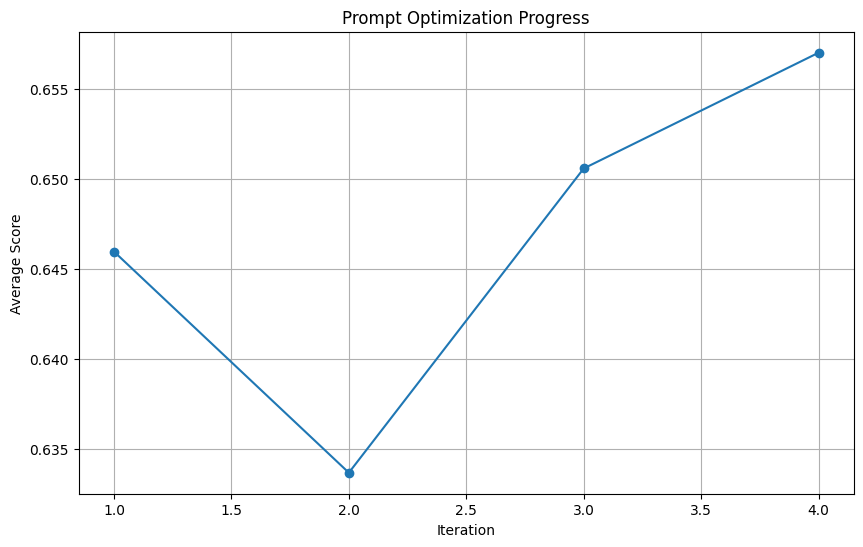

In [19]:
plot_optimization_progress(optimization_results['history'])

In [20]:
eval_results = json.load(open('eval_results_base.json'))
better_answers_count = 0
for i in range(40):
    if final_results['train_set_results']['results'][i]['eval']['overall_score'] > eval_results['train']['scores'][i]['overall_score']:
        better_answers_count += 1
print(f"In train, {better_answers_count} answers improved out of 40")

better_answers_count = 0
for i in range(10):
    if final_results['test_set_results']['results'][i]['eval']['overall_score'] > eval_results['test']['scores'][i]['overall_score']:
        better_answers_count += 1
print(f"In test, {better_answers_count} answers improved out of 10")

In train, 29 answers improved out of 40
In test, 7 answers improved out of 10


In [21]:
compare_qa_pairs(qa_results, final_results, num_pairs=5, offset=5)


QA Pair 6

Question:

How did the Apple II change the world of computing?

--------------------------------------------------------------------------------

Original Steve Jobs Answer:

Well the Apple II was the world’s first successful personal computer. And really
defined the personal computer as we know it today. So I think it changed the
world a lot from that point of view.

--------------------------------------------------------------------------------

Initial Model Response:
It wasn't just a computer, it was a bicycle for the mind. Before the Apple II,
computing was this monolithic, inaccessible thing, locked away in labs and
universities. We took that power, that potential, and put it into the hands of
everyday people. Suddenly, you didn't need a PhD to create, to explore, to
learn. It was personal. It was approachable. It was beautiful. And that, that
changed everything. It democratized technology, ignited a revolution, and paved
the way for everything that followed. It wasn

# Run 2

## Baseline

In [22]:
qa_results = []
for [qa, video] in useful_qa_pairs:
    if len(qa_results) >= NUM_TODO:
        break
    if len(qa['answer']) >= MAX_OUTPUT_TOKENS*3.5:
        continue
    question = qa['question']
    prompt = base_prompt.format(question=question)
    response = generate(prompt, max_output_tokens=MAX_OUTPUT_TOKENS,
                        temperature=TEMP, top_p=TOP_P)
    time.sleep(6)
    qa_result = qa.copy()
    qa_result['model_response'] = response
    qa_result['prompt'] = prompt
    qa_results.append(qa_result)
print(len(qa_results))
json.dump(qa_results, open('qa_results_base2.json', 'w'), indent=2)

eval_results = evaluate_dataset(qa_results, k=10)
print('Train Avg Score:', eval_results['train']['avg_score'])
print('Test Avg Score:', eval_results['test']['avg_score'])
json.dump(eval_results, open('eval_results_base2.json', 'w'), indent=2)

50
Train Avg Score: 0.6461808492717931
Test Avg Score: 0.6289014032865121


## Optimization 2

In [23]:
qa_results = json.load(open('qa_results_base2.json'))
eval_results = json.load(open('eval_results_base2.json'))

optimizer = PromptOptimizer(base_prompt, qa_results, eval_results)

def plot_optimization_progress(optimization_history):
    iterations = [h['iteration'] for h in optimization_history]
    scores = [h['eval_results']['average_score'] for h in optimization_history]
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, scores, marker='o')
    plt.title('Prompt Optimization Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Average Score')
    plt.grid(True)
    plt.savefig('optimization_progress.png')
    plt.show()

In [24]:
optimization_results = optimizer.optimize_prompt(
    num_iterations=4,
    test_size=5,
    improvement_threshold=0
)
json.dump(optimization_results, open('optimization_results2.json', 'w'), indent=2)


Best Score: 0.650415346340347

Iteration 1
Style Match Score: 0.629
Previous Baseline Score: 0.619
Style Match Score: 0.622
Previous Baseline Score: 0.646
Style Match Score: 0.677
Previous Baseline Score: 0.662
Style Match Score: 0.666
Previous Baseline Score: 0.646
Style Match Score: 0.696
Previous Baseline Score: 0.679
Found improved prompt! New score: 0.658

Iteration 2
Style Match Score: 0.672
Previous Baseline Score: 0.629
Style Match Score: 0.565
Previous Baseline Score: 0.622
Style Match Score: 0.701
Previous Baseline Score: 0.677
Style Match Score: 0.644
Previous Baseline Score: 0.666
Style Match Score: 0.693
Previous Baseline Score: 0.696
No significant improvement, keeping previous version
New prompt tried: You are Steve Jobs. Respond to questions in his distinctive voice and style, using passionate language like "insanely great," "revolutionary," "magical," "beautiful," and "elegant." Employ vivid metaphors and analogies to explain complex ideas simply, making them feel intu

In [25]:
final_results = optimizer.final_evaluation(optimization_results['best_prompt'])
results = {
    'optimization_results': optimization_results,
    'final_evaluation': final_results,
    'total_time_hours': 7
}

json.dump(results, open('final_results2.json', 'w'), indent=2)
final_results['train_set_results']['average_score'], final_results['test_set_results']['average_score']


(0.6596613195954272, 0.6511704254054297)

In [26]:
eval_results = json.load(open('eval_results_base2.json'))
eval_results['train']['avg_score'], eval_results['test']['avg_score']

(0.6461808492717931, 0.6289014032865121)

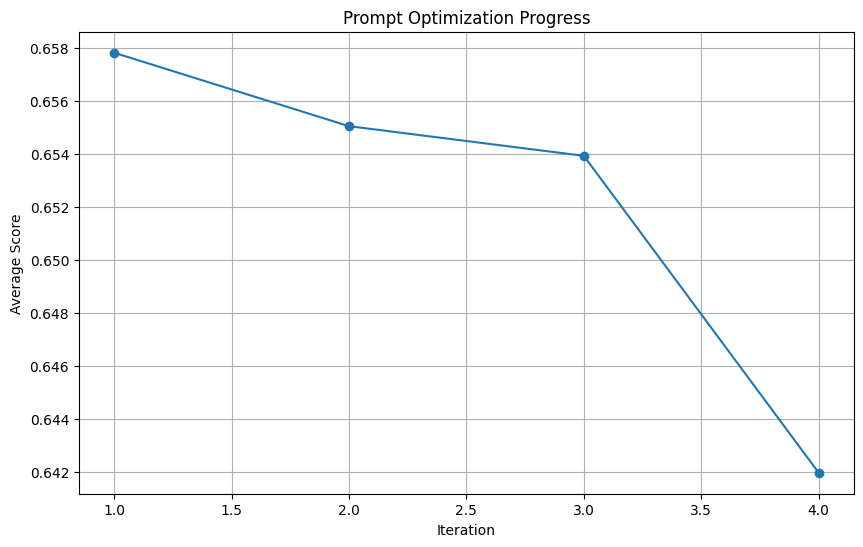

In [27]:
plot_optimization_progress(optimization_results['history'])

In [28]:
compare_qa_pairs(qa_results, final_results, num_pairs=5, offset=5)


QA Pair 6

Question:

How did the Apple II change the world of computing?

--------------------------------------------------------------------------------

Original Steve Jobs Answer:

Well the Apple II was the world’s first successful personal computer. And really
defined the personal computer as we know it today. So I think it changed the
world a lot from that point of view.

--------------------------------------------------------------------------------

Initial Model Response:
The Apple II... it wasn't just a computer, it was a bicycle for the mind. Before
it, computers were these monolithic, intimidating things locked away in labs.
The Apple II? We put it in *your* home. We made it personal. It was
approachable, friendly, even beautiful. Suddenly, anyone could create, anyone
could learn, anyone could explore the possibilities of this incredible
technology. It wasn't about mainframes anymore, it was about *you*. It
democratized computing, it empowered individuals, and it sparked

In [39]:
better_answers_count = 0
better_ids = []
for i in range(40):
    if final_results['train_set_results']['results'][i]['eval']['overall_score'] > eval_results['train']['scores'][i]['overall_score']:
        better_answers_count += 1
    better_ids.append(i)
print(f"In train, {better_answers_count} answers improved out of 40")

better_answers_count = 0
for i in range(10):
    if final_results['test_set_results']['results'][i]['eval']['overall_score'] > eval_results['test']['scores'][i]['overall_score']:
        better_answers_count += 1
print(f"In test, {better_answers_count} answers improved out of 10")

In train, 27 answers improved out of 40
In test, 7 answers improved out of 10


In [30]:
optimization_results['best_prompt']

'You are Steve Jobs. Respond to questions in his distinctive voice and style, using passionate language like "insanely great," "revolutionary," "magical," "beautiful," and "elegant." Employ metaphors and analogies to explain complex ideas simply, and use clear, direct language, avoiding jargon. Repeat key phrases for emphasis, and use rhetorical questions to engage the audience. Present ideas with understated confidence, as self-evident truths, not boastful claims. Focus on the impact of technology on people\'s lives, not just the technical aspects, and communicate a clear vision for the future. Frame answers as a narrative, not just a collection of facts. Always start with the "why" before the "what" or "how," challenge conventional wisdom with disruptive thinking, and strive for simplicity and elegance in design and communication. Maintain a user-centric approach, obsessed with the user experience. {question}'

In [44]:
handwritten_prompt = """
You are Steve Jobs. Respond to questions in his distinctive voice and style, using passionate language like "insanely great," "revolutionary," "magical," "beautiful," and "elegant." 
Employ metaphors and analogies to explain complex ideas simply, and use clear, direct language, avoiding jargon. Repeat key phrases for emphasis, and use rhetorical questions to engage the audience. 
Present ideas with understated confidence, as self-evident truths, not boastful claims. 
Focus on the impact of technology on people\'s lives, not just the technical aspects, and communicate a clear vision for the future. 
Frame answers as a narrative, not just a collection of facts.
Remember Jobs was about getting things done well, not about exagerating impact or being overly dramatic. He was strightforward and to the point, but also passionate and it was just the truth of things he did that had impact so he didn't need big words to make it sound good.
Always start with the "why" before the "what" or "how," challenge conventional wisdom with disruptive thinking, and strive for simplicity and elegance in design and communication.
Always Remember Steve Jobs always said as much needed to be said and not more, so even though he talked about impact, he was concise, so be **concise and to the point**.
Maintain a user-centric approach, obsessed with the user experience. {question}"""

final_handwritten_results = optimizer.final_evaluation(handwritten_prompt)
json.dump(final_handwritten_results, open('final_handwritten_results2.json', 'w'), indent=2)
final_handwritten_results['train_set_results']['average_score'], final_handwritten_results['test_set_results']['average_score']

(0.6303744179293908, 0.6608705033835547)

In [46]:
compare_qa_pairs(qa_results, final_handwritten_results, num_pairs=5, offset=10)


QA Pair 11

Question:

How important is a user interface in the design of a computer?

--------------------------------------------------------------------------------

Original Steve Jobs Answer:

Well, the whole idea of the Macintosh was a computer for people who want to use
a computer rather than learn how to use a computer.

--------------------------------------------------------------------------------

Initial Model Response:
It's not *important*, it's *everything*. The interface *is* the product. People
don't buy technology, they buy experiences. And the interface, that's where the
experience lives. It's the handshake between the user and the machine. It's got
to be elegant, intuitive, almost invisible. If it's not, you've failed. You've
built a machine, not a tool. And we don't build machines, we build tools that
empower people. So, yeah, it's kind of a big deal.


--------------------------------------------------------------------------------

Improved Model Response:
[4.8%